## Import Dependencies

In [36]:
import pandas as pd
import numpy as np
import psycopg2
import re
import config as creds
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# allow plots to appear directly in the notebook
%matplotlib inline

## Connect to Postgres RDS

In [2]:
DATABASES = {
    'production':{
        'NAME': creds.PGDATABASE,
        'USER': creds.PGUSER,
        'PASSWORD': creds.PGPASSWORD,
        'HOST': creds.PGHOST,
        'PORT': 5432,
    },
}

#Choose the database to use
db = DATABASES['production']

In [3]:
#construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db['USER'],
    password = db['PASSWORD'],
    host = db['HOST'],
    port = db['PORT'],
    database = db['NAME'],
)

# create sqlalchemy engine
engine = create_engine(engine_string)

## Load Data

In [5]:
#Create dataframe from database
biodiversity_df = pd.read_sql_table('biodiversity_df', engine)

In [6]:
print(biodiversity_df.shape)

(57, 27)


## Correlation Exploration

In [7]:
biodiversity_df.corr(method='pearson')

,ACRES,Latitude,Longitude,Average,Native,Not Native,Unknown,total_species,NonNative_Ratio,Algae,...,Fungi,Insect,Invertebrate,Mammal,Nonvascular Plant,Reptile,Slug/Snail,Spider/Scorpion,Vascular Plant,NonNative_to_Native_Ratio
ACRES,1.000000,0.587047,-0.493968,-0.110923,0.054969,-0.203815,-0.024700,-0.042575,-0.328382,0.034666,...,0.065866,-0.026959,-0.066732,0.053261,-0.056205,-0.157489,0.013106,-0.014263,0.027527,-0.273120
Latitude,0.587047,1.000000,-0.489089,-0.163184,-0.167521,-0.503996,-0.007645,-0.295138,-0.582344,0.022840,...,0.172110,-0.227685,-0.123073,-0.040733,0.093167,-0.560898,-0.182882,-0.268887,-0.160814,-0.569199
Longitude,-0.493968,-0.489089,1.000000,0.228686,0.057916,-0.026062,0.165114,0.096098,0.164613,-0.009937,...,-0.046188,-0.009840,-0.155107,0.032996,-0.097490,0.401617,-0.102497,-0.069166,0.166563,0.106986
Average,-0.110923,-0.163184,0.228686,1.000000,0.607455,0.251308,0.093850,0.546664,0.144441,0.093202,...,0.123059,0.537934,0.031792,0.208188,0.346885,0.177355,0.254151,0.510313,0.442573,0.074983
Native,0.054969,-0.167521,0.057916,0.607455,1.000000,0.321662,0.125573,0.856458,0.084129,0.167608,...,0.194297,0.464831,0.187222,0.359289,0.401155,0.320771,0.347564,0.425463,0.721978,-0.004641
Not Native,-0.203815,-0.503996,-0.026062,0.251308,0.321662,1.000000,0.059593,0.595615,0.912836,-0.059500,...,0.081574,0.490255,0.379697,-0.248238,0.228443,0.034064,0.401213,0.379305,0.246164,0.888957
Unknown,-0.024700,-0.007645,0.165114,0.093850,0.125573,0.059593,1.000000,0.501329,-0.027920,0.380896,...,0.232163,0.298437,0.068270,-0.043201,0.307796,-0.081981,0.072958,0.084455,0.166063,0.097402
total_species,-0.042575,-0.295138,0.096098,0.546664,0.856458,0.595615,0.501329,1.000000,0.365741,0.245532,...,0.254769,0.611320,0.289335,0.146142,0.479471,0.202547,0.410106,0.461124,0.652855,0.345014
NonNative_Ratio,-0.328382,-0.582344,0.164613,0.144441,0.084129,0.912836,-0.027920,0.365741,1.000000,-0.131248,...,-0.012756,0.298824,0.310709,-0.309045,0.086184,0.006656,0.282534,0.201586,0.092393,0.964822
Algae,0.034666,0.022840,-0.009937,0.093202,0.167608,-0.059500,0.380896,0.245532,-0.131248,1.000000,...,0.259700,0.476535,0.463789,0.251266,0.213565,-0.015181,0.387481,0.087883,0.205354,-0.110491


<AxesSubplot:>

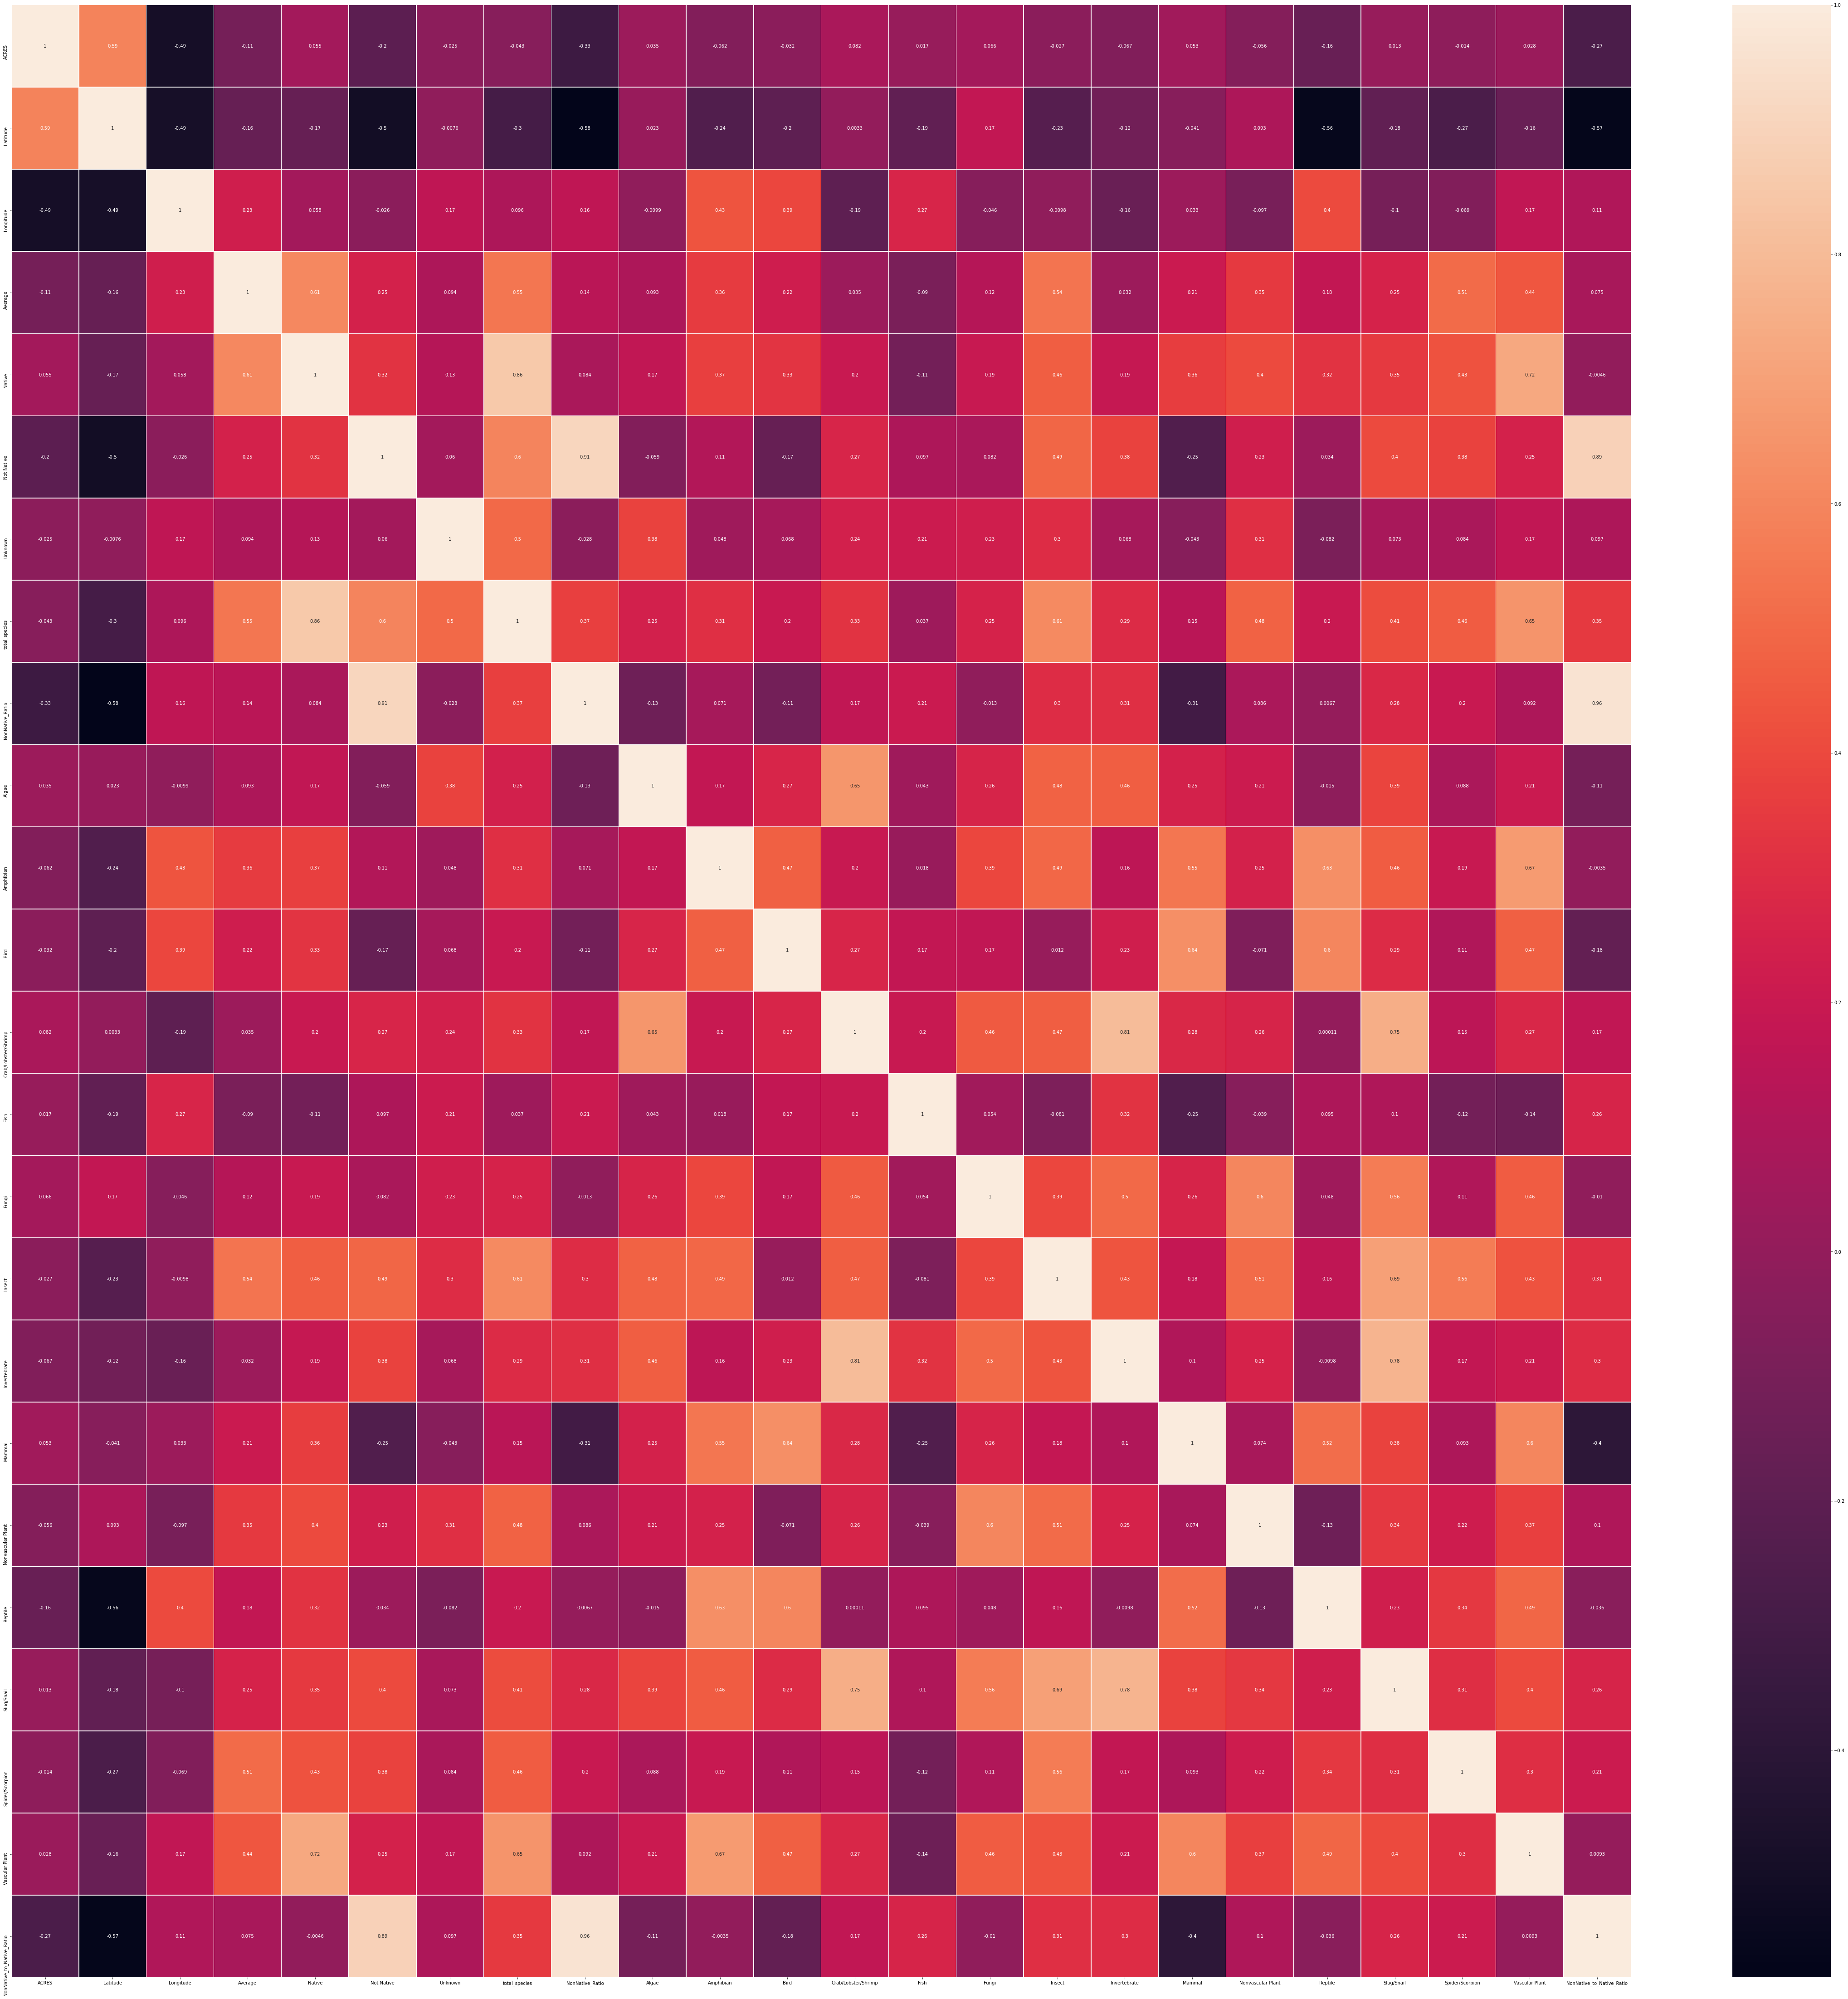

In [8]:
fig, ax = plt.subplots(figsize=(80,80))
sns.heatmap(biodiversity_df.corr(method='pearson'), annot=True, linewidths=.5, ax=ax)

C:\Users\ohugh\Anaconda3\envs\mlenv\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



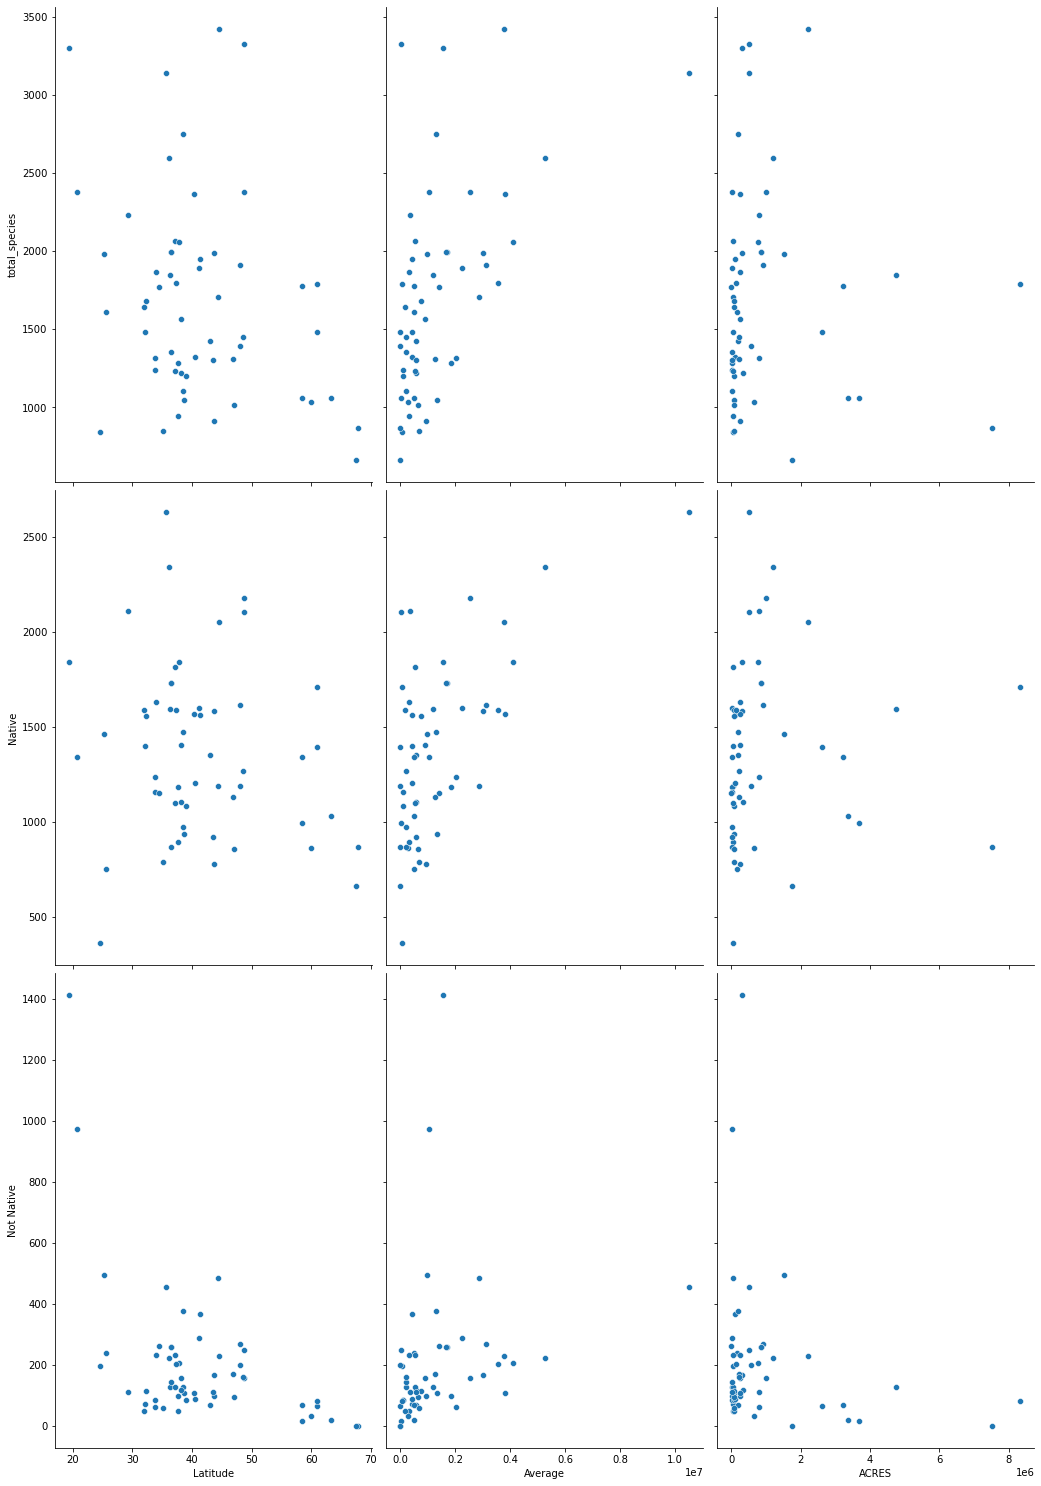

In [74]:
# Visualize the relationship between the features and the response using scatterplots
sns.pairplot(biodiversity_df, x_vars=['Latitude', 'Average', 'ACRES'], y_vars=['total_species', 'Native', 'Not Native'], size=7, aspect=.7)

##  Regression Model Testing

#### Park Visitation and Non Native Species

In [75]:
X = biodiversity_df.Average.values.reshape(-1,1)

In [76]:
y = biodiversity_df['Not Native'].values.reshape(-1,1)

In [77]:
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
print(y_pred.shape)

(57, 1)


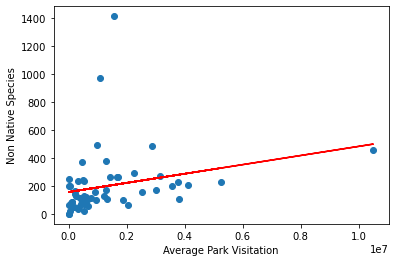

In [78]:
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Average Park Visitation')
plt.ylabel('Non Native Species')
plt.show()

In [79]:
#Calculate Root Mean Square Error of model
print('RMSE=>',  np.sqrt(mean_squared_error(y, y_pred)))

#Calculate R2 Score
print('R2 Score', metrics.r2_score(y, y_pred))

RMSE=> 217.44774855918524
R2 Score 0.06315550198271114


In [80]:
hover_label = biodiversity_df['Park Name']
fig = px.scatter(x= biodiversity_df['Average'], 
                 y=biodiversity_df['Not Native'], 
                color=biodiversity_df['Park Name'])

fig.update_layout(title='Park Visitation and Non Native Species')
fig.update_layout(
xaxis={'title': 'Average Park Visitation'},
yaxis={'title': 'Number Non Native Species'})

fig.show()

In [81]:
#Drop Hawaii Park outliers
biodiversity_df_noHawaii = biodiversity_df.drop([27, 28])
biodiversity_df_noHawaii

#Drop Great Smoky National Park outlier
biodiversity_df_drop_outliers = biodiversity_df_noHawaii.drop([25])

In [82]:
X = biodiversity_df_noHawaii.Average.values.reshape(-1,1)
y = biodiversity_df_noHawaii['Not Native'].values.reshape(-1,1)

In [83]:
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
print(y_pred.shape)

(55, 1)


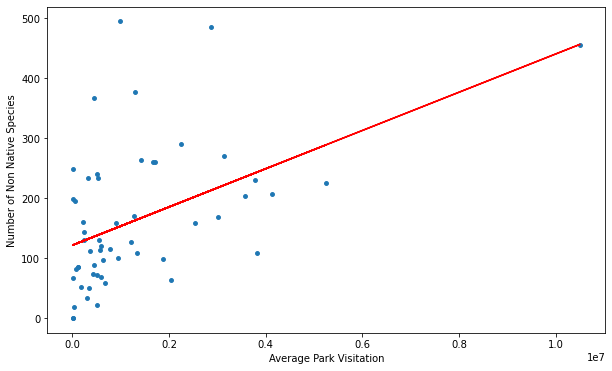

In [84]:
plt.figure(figsize=(10,6))
plt.scatter(X,y,s=15)
plt.plot(X, y_pred, color='red')
plt.xlabel('Average Park Visitation')
plt.ylabel('Number of Non Native Species')
plt.show()

In [47]:
#Calculate Root Mean Square Error
print('RMSE =>',  np.sqrt(mean_squared_error(y, y_pred)))
#Calculate R2 Score for Model
print('R2 Score', metrics.r2_score(y, y_pred))

RMSE => 100.59103910682107
R2 Score 0.23820639721901393


(54, 1)


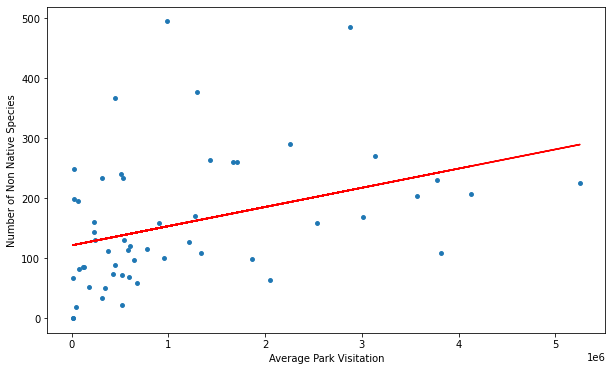

In [72]:
#Remove Great Smoky Mtn. National Park as an Outlier for Visitation
X = biodiversity_df_drop_outliers.Average.values.reshape(-1,1)
y = biodiversity_df_drop_outliers['Not Native'].values.reshape(-1,1)

#Define and Fit Model
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
print(y_pred.shape)

#Plot Figure
plt.figure(figsize=(10,6))
plt.scatter(X,y,s=15)
plt.plot(X, y_pred, color='red')
plt.xlabel('Average Park Visitation')
plt.ylabel('Number of Non Native Species')
plt.show()

In [73]:
#Calculate Root Mean Square Error
print('RMSE =>',  np.sqrt(mean_squared_error(y, y_pred)))
#Calculate R2 Score for Model
print('R2 Score', metrics.r2_score(y, y_pred))

RMSE => 101.5180536539457
R2 Score 0.13482127476068795


#### Park Size and Total Number of Species (Species Richness)

In [85]:
X = biodiversity_df.ACRES.values.reshape(-1,1)
y = biodiversity_df.total_species.values.reshape(-1,1)

In [86]:
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
print(y_pred.shape)

(57, 1)


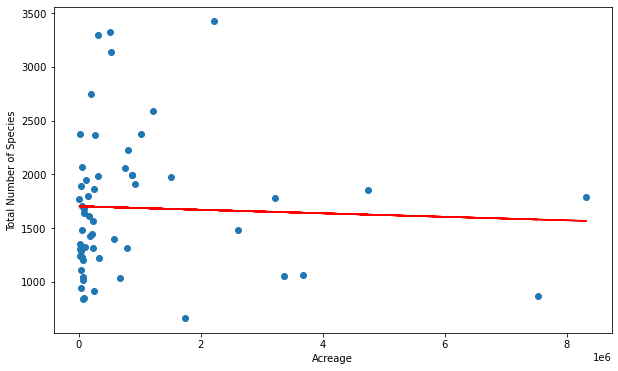

In [87]:
plt.figure(figsize=(10,6))
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Acreage')
plt.ylabel('Total Number of Species')
plt.show()

In [51]:
#Calculate Root Mean Square Error
mean_squared_error(y, y_pred)
print('RMSE =>',  np.sqrt(mean_squared_error(y, y_pred)))
#Calculate R2 score
metrics.r2_score(y, y_pred)
print('R2 Score =', metrics.r2_score(y, y_pred))

RMSE => 643.7855562957948
R2 Score = 0.0018126003894950449


#### Exploring Latitude and Species Richness

In [88]:
X= biodiversity_df.Latitude.values.reshape(-1,1)
y= biodiversity_df.total_species.values.reshape(-1,1)
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
print(y_pred.shape)

(57, 1)


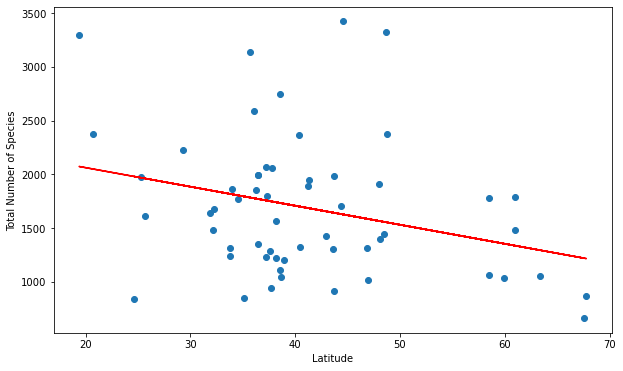

In [89]:
plt.figure(figsize=(10,6))
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Latitude')
plt.ylabel('Total Number of Species')
plt.show()

In [54]:
#Calculate Root Mean Square Error
print('RMSE =>', np.sqrt(mean_squared_error(y, y_pred)))

#Calculate R2 score

print('R2 Score', metrics.r2_score(y, y_pred))

RMSE => 615.6661796978447
R2 Score 0.0871062785899187


####  Exploring Latitude and Non Native Species

(57, 1)


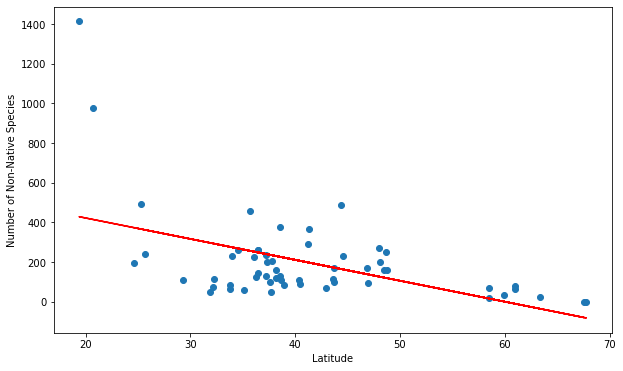

In [90]:
X = biodiversity_df.Latitude.values.reshape(-1,1)
y = biodiversity_df['Not Native'].values.reshape(-1,1)

model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
print(y_pred.shape)

plt.figure(figsize=(10,6))
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Latitude')
plt.ylabel('Number of Non-Native Species')
plt.show()

In [59]:
#Calculate Root Mean Square Error
print('RMSE for Linear Regression=>', np.sqrt(mean_squared_error(y, y_pred)))

#Calculate R2 Score for Model
print('R2 Score =', metrics.r2_score(y, y_pred))

RMSE for Linear Regression=> 194.03817855730256
R2 Score = 0.2540116274894847


In [57]:
# importing libraries for polynomial transform
from sklearn.preprocessing import PolynomialFeatures
# for creating pipeline
from sklearn.pipeline import Pipeline
# creating pipeline and fitting it on data
Input=[('polynomial',PolynomialFeatures(degree=2)),('modal',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(X,y)

Pipeline(steps=[('polynomial', PolynomialFeatures()),
                ('modal', LinearRegression())])

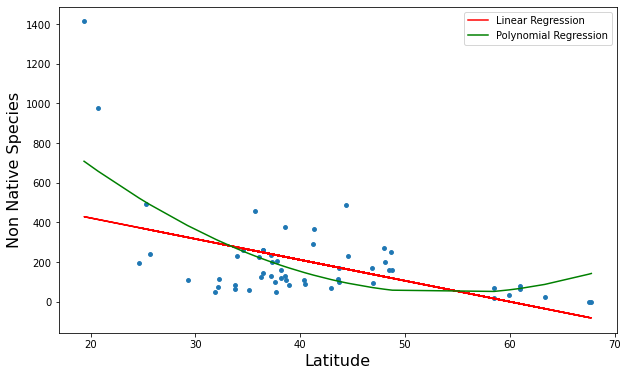

In [58]:
poly_pred=pipe.predict(X)
#sorting predicted values with respect to predictor
sorted_zip = sorted(zip(X,poly_pred))
X_poly, poly_pred = zip(*sorted_zip)
#plotting predictions
plt.figure(figsize=(10,6))
plt.scatter(X,y,s=15)
plt.plot(X,y_pred,color='r',label='Linear Regression')
plt.plot(X_poly,poly_pred,color='g',label='Polynomial Regression')
plt.xlabel('Latitude',fontsize=16)
plt.ylabel('Non Native Species',fontsize=16)
plt.legend()
plt.show()

In [60]:
#Calculate Root Mean Square Error
print('RMSE for Polynomial Regression=>', np.sqrt(mean_squared_error(y, poly_pred)))

#Calculate R2 Score
print('R2 Score', metrics.r2_score(y, y_pred))

RMSE for Polynomial Regression=> 264.2789178951947
R2 Score 0.2540116274894847


(55, 1)


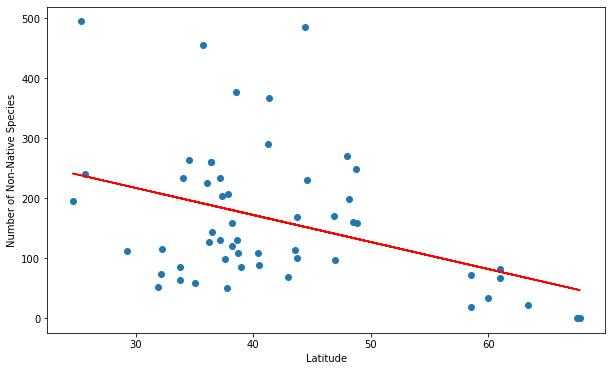

In [91]:
#Remove Hawaii Outliers and re-run linear regression

X = biodiversity_df_noHawaii.Latitude.values.reshape(-1,1)
y = biodiversity_df_noHawaii['Not Native'].values.reshape(-1,1)

model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
print(y_pred.shape)

plt.figure(figsize=(10,6))
plt.scatter(X,y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Latitude')
plt.ylabel('Number of Non-Native Species')
plt.show()

In [62]:
#Calculate Root Mean Square Error
print('RMSE for Linear Regression=>', np.sqrt(mean_squared_error(y, y_pred)))

#Calculate R2 Score for Model
print('R2 Score =', metrics.r2_score(y, y_pred))

RMSE for Linear Regression=> 105.78266636745828
R2 Score = 0.15754298330126237
